In [1]:
#Import Required Libraries


# Basic utilities
import re
import numpy as np
import pandas as pd

# Data splitting and feature extraction
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# Machine learning models
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

# Model evaluation metrics
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score,
    f1_score,
    roc_curve,
    auc,
    precision_recall_curve,
    average_precision_score
)

# Visualisation libraries
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Label processing (for ROC curve in multi-class setting)
from sklearn.preprocessing import label_binarize

# Natural Language Processing (NLP)
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Deep Learning (Transformer-based model)
import torch
from transformers import (
    DistilBertTokenizerFast,
    DistilBertForSequenceClassification,
    Trainer,
    TrainingArguments
)

# Download required NLTK resources

nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("omw-1.4")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [2]:
# Load the Amazon Fine Food Reviews dataset
df = pd.read_csv("Reviews.csv")

# Display first few rows to understand the structure
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568428 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


In [4]:
# Check for fully duplicated rows in the dataset
df.duplicated().sum()

np.int64(0)

In [5]:
# Check for duplicate review texts specifically
df["Text"].duplicated().sum()

np.int64(174875)

In [6]:
# Remove duplicate reviews based on the review text
df = df.drop_duplicates(subset="Text")

In [7]:
df.shape

(393579, 10)

In [8]:
# Re-check for duplicate review texts after cleaning
df["Text"].duplicated().sum()

np.int64(0)

In [9]:
# Check for missing values in each column
df.isnull().sum()

,0
Id,0
ProductId,0
UserId,0
ProfileName,16
HelpfulnessNumerator,0
HelpfulnessDenominator,0
Score,0
Time,0
Summary,3
Text,0


In [10]:
# Check for reviews that are empty or contain only whitespace
df["Text"].str.strip().eq("").sum()

np.int64(0)

In [11]:
# Keep only the relevant columns for text classification
df = df[["Text", "Score"]]

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 393579 entries, 0 to 568453
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   Text    393579 non-null  object
 1   Score   393579 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 9.0+ MB


In [13]:
# Check distribution of review scores (1–5)
df["Score"].value_counts().sort_index()

,count
Score,
1,36275
2,20792
3,29754
4,56042
5,250716


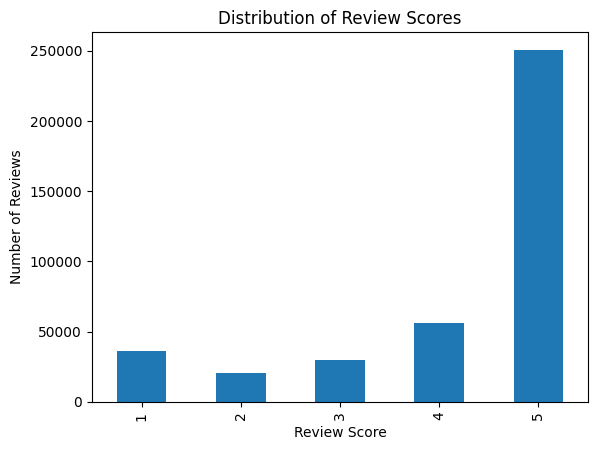

In [14]:
# Plot the distribution of review scores (1–5)
df["Score"].value_counts().sort_index().plot(kind="bar")

# Add labels and title for clarity
plt.xlabel("Review Score")
plt.ylabel("Number of Reviews")
plt.title("Distribution of Review Scores")
plt.show()

In [15]:

# Calculate percentage distribution of review scores
(df["Score"].value_counts(normalize=True)
      .sort_index()
      .mul(100)
      .round(2)
)

,proportion
Score,
1,9.22
2,5.28
3,7.56
4,14.24
5,63.70


In [16]:
# Map numerical review scores to sentiment categories
def map_sentiment(score):
    if score in [1, 2]:
        return "Negative"
    elif score == 3:
        return "Neutral"
    else:
        return "Positive"

# Apply sentiment mapping
df["sentiment"] = df["Score"].apply(map_sentiment)

In [17]:
# Absolute count of sentiment classes
df["sentiment"].value_counts()

,count
sentiment,
Positive,306758
Negative,57067
Neutral,29754


In [18]:
# Percentage distribution of sentiment classes
(
    df["sentiment"].value_counts(normalize=True)
      .mul(100)
      .round(2)
)

,proportion
sentiment,
Positive,77.94
Negative,14.50
Neutral,7.56


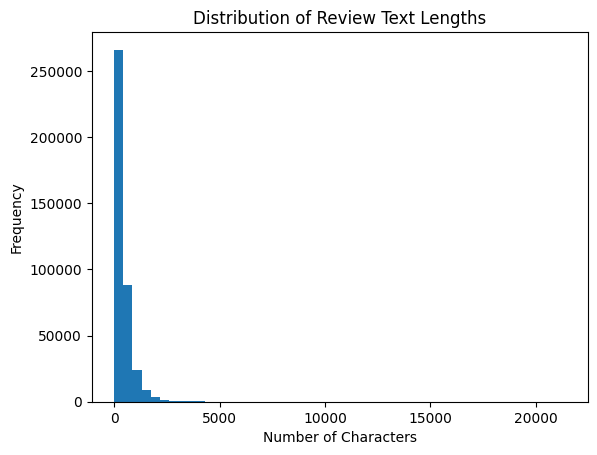

In [19]:
# Calculate length of each review (number of characters)
df["text_length"] = df["Text"].str.len()

# Plot distribution of review lengths
df["text_length"].plot(kind="hist", bins=50)

plt.xlabel("Number of Characters")
plt.ylabel("Frequency")
plt.title("Distribution of Review Text Lengths")
plt.show()

In [20]:
# Basic Text Cleaning

def clean_text(text):
    """
    Perform basic text cleaning:
    - Convert text to lowercase
    - Remove non-alphabetic characters
    - Remove extra whitespace
    """
    text = text.lower()
    text = re.sub(r"[^a-z\s]", " ", text)  # keep only letters and spaces
    text = re.sub(r"\s+", " ", text).strip()
    return text

In [21]:
# Apply basic text cleaning to the review text
df["clean_text"] = df["Text"].apply(clean_text)

In [22]:
# Display random samples to compare original and cleaned text
df.sample(5, random_state=42)[["Text", "clean_text"]]

,Text,clean_text
508413,I have tried just about every gluten free past...,i have tried just about every gluten free past...
351680,I routinely purchase my dog treats through Ama...,i routinely purchase my dog treats through ama...
206063,I bought this product and love it. I have deci...,i bought this product and love it i have decid...
129501,I've been bouncing around from one brand of gr...,i ve been bouncing around from one brand of gr...
9569,I get these for $4.34 at my local health food ...,i get these for at my local health food store ...


In [23]:
# Load English stopwords
stop_words = set(stopwords.words("english"))

# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

# Number of stopwords (for reference)
len(stop_words)

198

In [24]:
def clean_text_advanced(text):
    """
    Perform advanced text preprocessing:
    - Convert text to lowercase
    - Remove non-alphabetic characters
    - Normalize whitespace
    - Remove stopwords
    - Apply lemmatization
    """
    text = text.lower()
    text = re.sub(r"[^a-z\s]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()

    # Tokenization
    tokens = text.split()

    # Stopword removal
    tokens = [t for t in tokens if t not in stop_words]

    # Lemmatization
    tokens = [lemmatizer.lemmatize(t) for t in tokens]

    return " ".join(tokens)

In [25]:
# Apply advanced text preprocessing
df["clean_text_adv"] = df["Text"].apply(clean_text_advanced)

In [26]:
# Compare original, basic cleaned, and advanced cleaned text
df.sample(5, random_state=42)[
    ["Text", "clean_text", "clean_text_adv"]
]

,Text,clean_text,clean_text_adv
508413,I have tried just about every gluten free past...,i have tried just about every gluten free past...,tried every gluten free pasta available hand b...
351680,I routinely purchase my dog treats through Ama...,i routinely purchase my dog treats through ama...,routinely purchase dog treat amazon convenienc...
206063,I bought this product and love it. I have deci...,i bought this product and love it i have decid...,bought product love decided buy much flour fut...
129501,I've been bouncing around from one brand of gr...,i ve been bouncing around from one brand of gr...,bouncing around one brand green tea another ti...
9569,I get these for $4.34 at my local health food ...,i get these for at my local health food store ...,get local health food store price suck one bes...


In [27]:
# Length of basic cleaned text
df["clean_length"] = df["clean_text"].str.len()

# Length of advanced cleaned text
df["adv_length"] = df["clean_text_adv"].str.len()

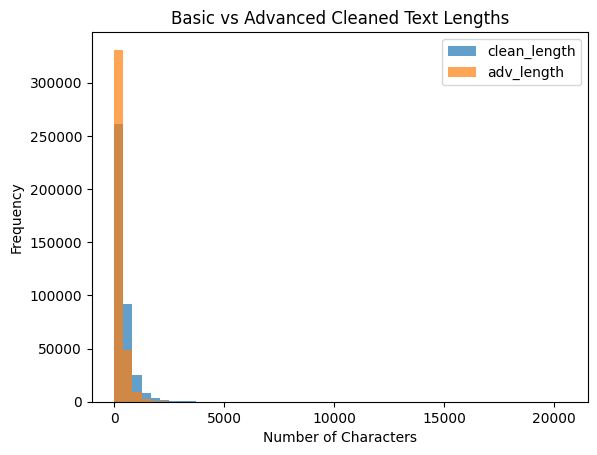

In [28]:
# Plot comparison
df[["clean_length", "adv_length"]].plot(kind="hist", bins=50, alpha=0.7)

plt.xlabel("Number of Characters")
plt.ylabel("Frequency")
plt.title("Basic vs Advanced Cleaned Text Lengths")
plt.show()

In [29]:
# TF-IDF Feature Extraction (Baseline Cleaned Text)

# Initialize TF-IDF vectorizer
tfidf_base = TfidfVectorizer(
    ngram_range=(1, 2),  # unigrams and bigrams
    min_df=5,            # ignore rare terms
    max_df=0.9           # ignore overly frequent terms
)

# Fit TF-IDF on basic cleaned text and transform it into feature vectors
X_base = tfidf_base.fit_transform(df["clean_text"])

# Display feature matrix shape
X_base.shape

(393579, 482343)

In [30]:
# TF-IDF Feature Extraction (Advanced Cleaned Text)


# Initialize TF-IDF vectorizer for advanced cleaned text
tfidf_adv = TfidfVectorizer(
    ngram_range=(1, 2),  # unigrams and bigrams
    min_df=5,            # remove rare terms
    max_df=0.9           # remove overly frequent terms
)

# Fit and transform advanced cleaned text
X_adv = tfidf_adv.fit_transform(df["clean_text_adv"])

# Display feature matrix shape
X_adv.shape

(393579, 459285)

In [31]:
print("Baseline vocabulary size:", len(tfidf_base.vocabulary_))
print("Advanced vocabulary size:", len(tfidf_adv.vocabulary_))

Baseline vocabulary size: 482343
Advanced vocabulary size: 459285


In [32]:
# Raw text features (used later for transformer-based model)
X_base_text = df["clean_text"]
X_adv_text  = df["clean_text_adv"]

# Target labels
y = df["sentiment"]

In [33]:
# Split raw text and labels (stratified to preserve class distribution)
Xb_train, Xb_test, y_train, y_test = train_test_split(
    X_base_text,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# Split for advanced cleaned text
# Labels are not reassigned here as y_train and y_test are already defined
Xa_train, Xa_test, _, _ = train_test_split(
    X_adv_text,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [34]:
# Fit TF-IDF on training data only (baseline)
Xb_train_vec = tfidf_base.fit_transform(Xb_train)

# Transform test data using the fitted vectorizer
Xb_test_vec  = tfidf_base.transform(Xb_test)

# Check shapes
Xb_train_vec.shape, Xb_test_vec.shape

((314863, 410144), (78716, 410144))

In [35]:
# Fit TF-IDF on advanced cleaned training text
Xa_train_vec = tfidf_adv.fit_transform(Xa_train)

# Transform advanced cleaned test text
Xa_test_vec  = tfidf_adv.transform(Xa_test)

# Check shapes
Xa_train_vec.shape, Xa_test_vec.shape

((314863, 378890), (78716, 378890))

In [36]:
# Initialize Multinomial Naive Bayes classifier
nb_base = MultinomialNB()

# Train the model using baseline TF-IDF features
nb_base.fit(Xb_train_vec, y_train)

MultinomialNB()

In [37]:
# Predict sentiment labels on test data
y_pred_nb_base = nb_base.predict(Xb_test_vec)

# Display classification report
print("Naive Bayes – Baseline preprocessing")
print(classification_report(y_test, y_pred_nb_base, digits=4))

Naive Bayes – Baseline preprocessing
              precision    recall  f1-score   support

    Negative     0.9061    0.1716    0.2886     11413
     Neutral     0.0000    0.0000    0.0000      5951
    Positive     0.8004    0.9987    0.8887     61352

    accuracy                         0.8033     78716
   macro avg     0.5688    0.3901    0.3924     78716
weighted avg     0.7552    0.8033    0.7345     78716



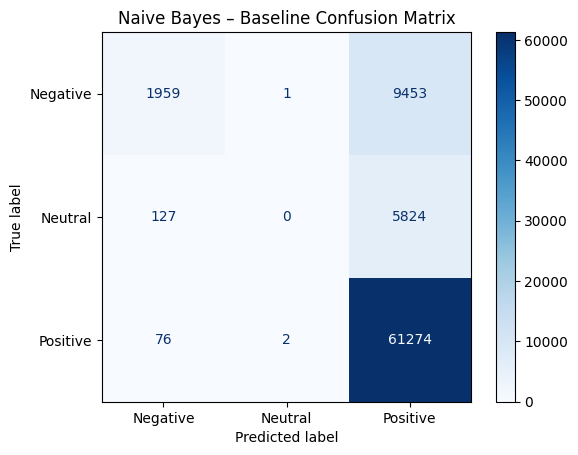

In [38]:
# Plot confusion matrix to visualize prediction errors
ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred_nb_base,
    cmap="Blues",
    values_format="d"
)

plt.title("Naive Bayes – Baseline Confusion Matrix")
plt.show()

In [39]:
# Get predicted probabilities for each class
y_proba_nb = nb_base.predict_proba(Xb_test_vec)

In [40]:
# Convert class labels to binary format for ROC computation
classes = nb_base.classes_
y_test_bin = label_binarize(y_test, classes=classes)

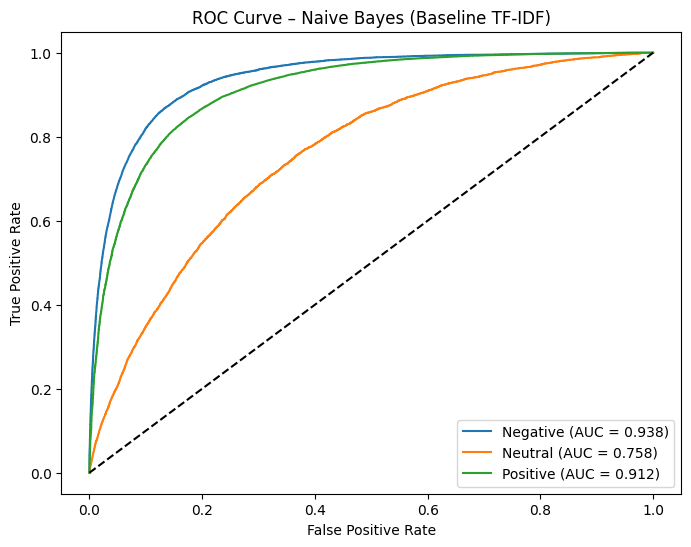

In [41]:
# Plot ROC curve for each sentiment class
plt.figure(figsize=(8, 6))

for i, class_label in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_proba_nb[:, i])
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f"{class_label} (AUC = {roc_auc:.3f})")

# Reference line (random classifier)
plt.plot([0, 1], [0, 1], "k--")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Naive Bayes (Baseline TF-IDF)")
plt.legend()
plt.show()

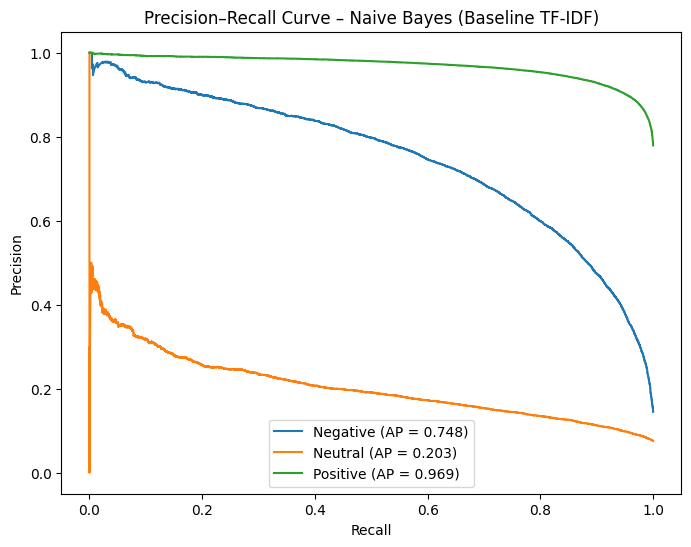

In [42]:
# Precision–Recall Curve – Naive Bayes

from sklearn.metrics import precision_recall_curve, average_precision_score

plt.figure(figsize=(8, 6))

for i, class_label in enumerate(classes):
    precision, recall, _ = precision_recall_curve(
        y_test_bin[:, i],
        y_proba_nb[:, i]
    )
    avg_precision = average_precision_score(
        y_test_bin[:, i],
        y_proba_nb[:, i]
    )

    plt.plot(
        recall,
        precision,
        label=f"{class_label} (AP = {avg_precision:.3f})"
    )

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve – Naive Bayes (Baseline TF-IDF)")
plt.legend()
plt.show()

In [43]:
# Testing on Unseen Data
# Example unseen reviews (not part of training or testing set)
unseen_reviews = [
    "This product is absolutely amazing and works perfectly",
    "The quality is okay but nothing special",
    "Very disappointed, waste of money"
]

# Convert unseen data into a DataFrame (same structure as training data)
unseen_df = pd.DataFrame({"Text": unseen_reviews})

# Apply the SAME preprocessing used for training
unseen_df["clean_text"] = unseen_df["Text"].apply(clean_text)

# Transform unseen text using the ALREADY FITTED TF-IDF vectorizer
unseen_vec = tfidf_base.transform(unseen_df["clean_text"])

# Predict sentiment on unseen data
unseen_predictions = nb_base.predict(unseen_vec)

# Display results
unseen_df["Predicted Sentiment"] = unseen_predictions
unseen_df

,Text,clean_text,Predicted Sentiment
0,This product is absolutely amazing and works p...,this product is absolutely amazing and works p...,Positive
1,The quality is okay but nothing special,the quality is okay but nothing special,Positive
2,"Very disappointed, waste of money",very disappointed waste of money,Negative


In [44]:
# Test Model on User-Entered Unseen Data

# Ask user to enter a review
user_review = input("Enter a product review to analyze sentiment: ")

# Convert user input into a DataFrame (consistent structure)
user_df = pd.DataFrame({"Text": [user_review]})

# Apply the SAME preprocessing used during training
user_df["clean_text"] = user_df["Text"].apply(clean_text)

# Transform text using the ALREADY FITTED TF-IDF vectorizer
user_vec = tfidf_base.transform(user_df["clean_text"])

# Predict sentiment
user_prediction = nb_base.predict(user_vec)

# Display result
print("\nPredicted Sentiment:", user_prediction[0])

Enter a product review to analyze sentiment: It is neither good nor bad, just acceptable

Predicted Sentiment: Negative


In [45]:
# Initialize Multinomial Naive Bayes classifier
nb_adv = MultinomialNB()

# Train the model using advanced TF-IDF features
nb_adv.fit(Xa_train_vec, y_train)

MultinomialNB()

In [46]:
# Predict sentiment labels on test data
y_pred_nb_adv = nb_adv.predict(Xa_test_vec)

# Display classification report
print("Naive Bayes – Advanced preprocessing")
print(classification_report(y_test, y_pred_nb_adv, digits=4))

Naive Bayes – Advanced preprocessing
              precision    recall  f1-score   support

    Negative     0.9201    0.1514    0.2600     11413
     Neutral     0.5000    0.0002    0.0003      5951
    Positive     0.7979    0.9992    0.8873     61352

    accuracy                         0.8008     78716
   macro avg     0.7393    0.3836    0.3825     78716
weighted avg     0.7931    0.8008    0.7293     78716



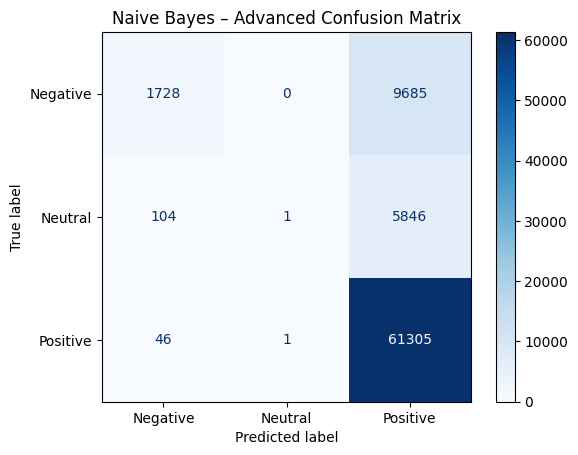

In [47]:
# Plot confusion matrix for Naive Bayes with advanced preprocessing
ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred_nb_adv,
    cmap="Blues",
    values_format="d"
)

plt.title("Naive Bayes – Advanced Confusion Matrix")
plt.show()

In [48]:
# Example unseen reviews
unseen_reviews = [
    "The product works fine but nothing stands out",
    "I am extremely unhappy with the quality",
    "Absolutely love this, would buy again"
]

# Create DataFrame
unseen_df = pd.DataFrame({"Text": unseen_reviews})

# Apply ADVANCED preprocessing
unseen_df["clean_text_adv"] = unseen_df["Text"].apply(clean_text_advanced)

# Transform using the ALREADY FITTED advanced TF-IDF vectorizer
unseen_vec_adv = tfidf_adv.transform(unseen_df["clean_text_adv"])

# Predict sentiment
unseen_predictions_adv = nb_adv.predict(unseen_vec_adv)

# Show results
unseen_df["Predicted Sentiment"] = unseen_predictions_adv
unseen_df

,Text,clean_text_adv,Predicted Sentiment
0,The product works fine but nothing stands out,product work fine nothing stand,Positive
1,I am extremely unhappy with the quality,extremely unhappy quality,Negative
2,"Absolutely love this, would buy again",absolutely love would buy,Positive


In [49]:
# Ask user for input
user_review = input("Enter a product review to analyze sentiment: ")

# Convert input to DataFrame
user_df = pd.DataFrame({"Text": [user_review]})

# Apply advanced preprocessing
user_df["clean_text_adv"] = user_df["Text"].apply(clean_text_advanced)

# Vectorize using trained TF-IDF
user_vec_adv = tfidf_adv.transform(user_df["clean_text_adv"])

# Predict sentiment
user_prediction_adv = nb_adv.predict(user_vec_adv)

print("\nPredicted Sentiment:", user_prediction_adv[0])

Enter a product review to analyze sentiment: It is neither good nor bad, just acceptable

Predicted Sentiment: Positive


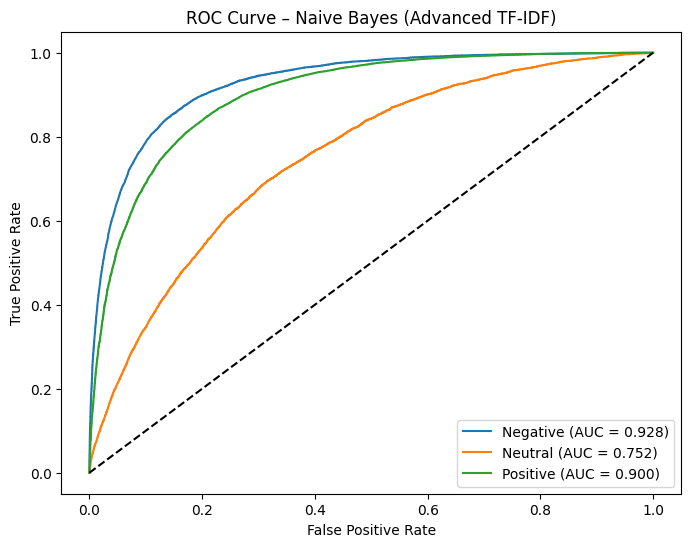

In [50]:
# Get predicted probabilities
y_proba_nb_adv = nb_adv.predict_proba(Xa_test_vec)

# Binarize true labels
classes = nb_adv.classes_
y_test_bin = label_binarize(y_test, classes=classes)

# Plot ROC curves
plt.figure(figsize=(8, 6))

for i, class_label in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_proba_nb_adv[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{class_label} (AUC = {roc_auc:.3f})")

# Random baseline
plt.plot([0, 1], [0, 1], "k--")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Naive Bayes (Advanced TF-IDF)")
plt.legend()
plt.show()

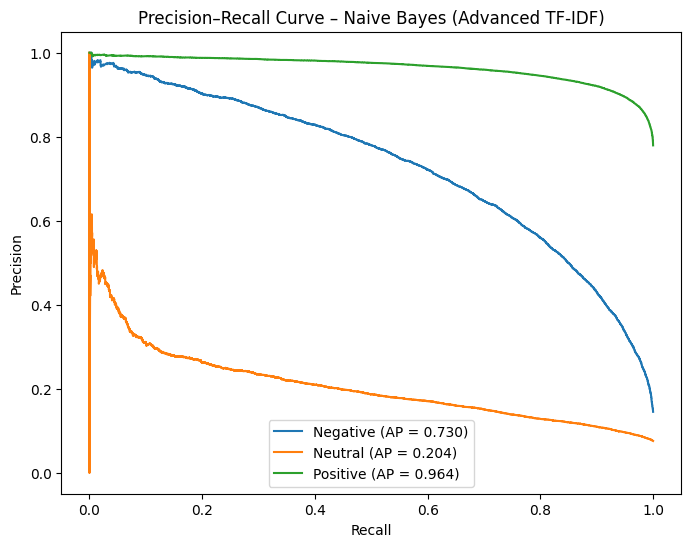

In [51]:
plt.figure(figsize=(8, 6))

for i, class_label in enumerate(classes):
    precision, recall, _ = precision_recall_curve(
        y_test_bin[:, i],
        y_proba_nb_adv[:, i]
    )
    avg_precision = average_precision_score(
        y_test_bin[:, i],
        y_proba_nb_adv[:, i]
    )

    plt.plot(
        recall,
        precision,
        label=f"{class_label} (AP = {avg_precision:.3f})"
    )

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve – Naive Bayes (Advanced TF-IDF)")
plt.legend()
plt.show()

In [52]:
# Initialize Logistic Regression classifier
lr_base = LogisticRegression(
    max_iter=2000,              # Ensure convergence for high-dimensional TF-IDF features
    n_jobs=-1,                  # Use all available CPU cores
    class_weight="balanced"     # Address class imbalance
)

In [53]:
# Train the model using baseline TF-IDF features
lr_base.fit(Xb_train_vec, y_train)

LogisticRegression(class_weight='balanced', max_iter=2000, n_jobs=-1)

In [54]:
# Predict sentiment labels on test data
y_pred_lr_base = lr_base.predict(Xb_test_vec)

# Display classification report
print("Logistic Regression – Baseline preprocessing")
print(classification_report(y_test, y_pred_lr_base, digits=4))

Logistic Regression – Baseline preprocessing
              precision    recall  f1-score   support

    Negative     0.7054    0.7845    0.7429     11413
     Neutral     0.3421    0.5613    0.4251      5951
    Positive     0.9683    0.8879    0.9264     61352

    accuracy                         0.8483     78716
   macro avg     0.6719    0.7446    0.6981     78716
weighted avg     0.8829    0.8483    0.8619     78716



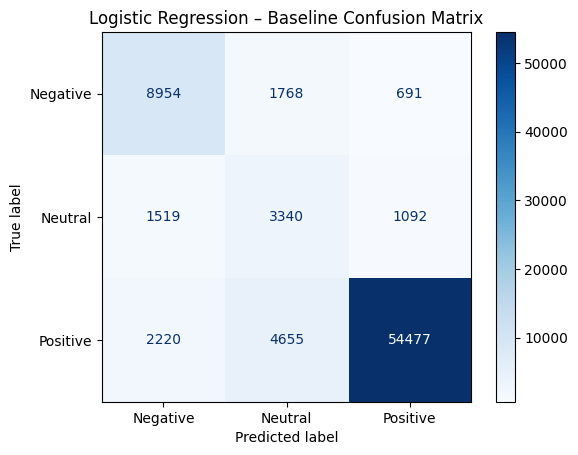

In [55]:
# Plot confusion matrix for Logistic Regression with baseline preprocessing
ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred_lr_base,
    cmap="Blues",
    values_format="d"
)

plt.title("Logistic Regression – Baseline Confusion Matrix")
plt.show()

In [56]:
# Example unseen reviews
unseen_reviews = [
    "The product works fine but nothing stands out",
    "I am very unhappy with the quality",
    "Absolutely love this product"
]

# Create DataFrame
unseen_df = pd.DataFrame({"Text": unseen_reviews})

# Apply BASELINE preprocessing
unseen_df["clean_text"] = unseen_df["Text"].apply(clean_text)

# Transform using the ALREADY FITTED baseline TF-IDF vectorizer
unseen_vec_base = tfidf_base.transform(unseen_df["clean_text"])

# Predict sentiment
unseen_predictions_lr_base = lr_base.predict(unseen_vec_base)

# Show results
unseen_df["Predicted Sentiment"] = unseen_predictions_lr_base
unseen_df

,Text,clean_text,Predicted Sentiment
0,The product works fine but nothing stands out,the product works fine but nothing stands out,Neutral
1,I am very unhappy with the quality,i am very unhappy with the quality,Negative
2,Absolutely love this product,absolutely love this product,Positive


In [57]:
# Ask user for input
user_review = input("Enter a product review to analyze sentiment: ")

# Convert input to DataFrame
user_df = pd.DataFrame({"Text": [user_review]})

# Apply baseline preprocessing
user_df["clean_text"] = user_df["Text"].apply(clean_text)

# Vectorize using trained TF-IDF
user_vec_base = tfidf_base.transform(user_df["clean_text"])

# Predict sentiment
user_prediction_lr_base = lr_base.predict(user_vec_base)

print("\nPredicted Sentiment:", user_prediction_lr_base[0])

Enter a product review to analyze sentiment: It is neither good nor bad, just acceptable

Predicted Sentiment: Neutral


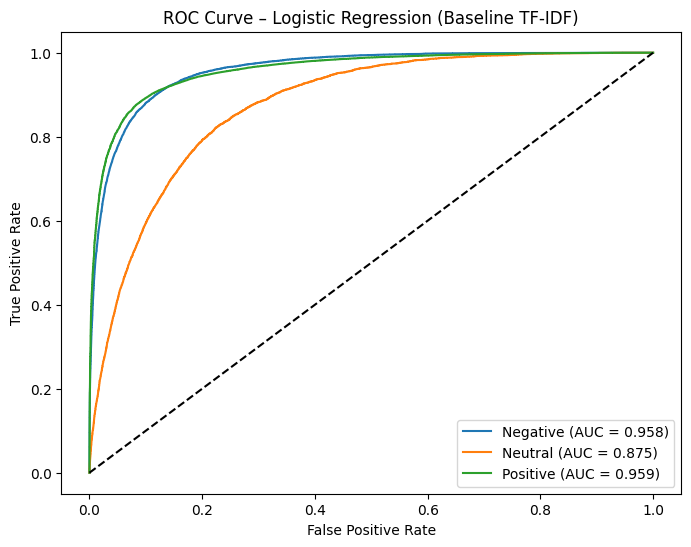

In [58]:
# Get predicted probabilities
y_proba_lr_base = lr_base.predict_proba(Xb_test_vec)

# Binarize true labels for multi-class ROC
classes = lr_base.classes_
y_test_bin = label_binarize(y_test, classes=classes)

# Plot ROC curves
plt.figure(figsize=(8, 6))

for i, class_label in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_proba_lr_base[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{class_label} (AUC = {roc_auc:.3f})")

# Random baseline
plt.plot([0, 1], [0, 1], "k--")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Logistic Regression (Baseline TF-IDF)")
plt.legend()
plt.show()

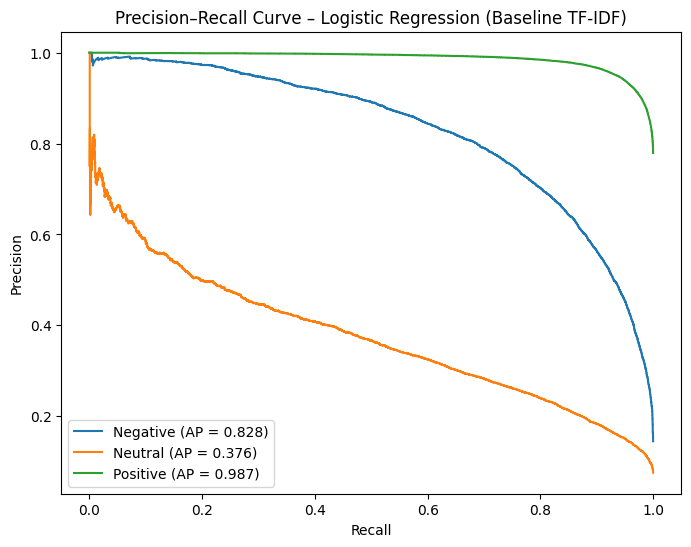

In [59]:
plt.figure(figsize=(8, 6))

for i, class_label in enumerate(classes):
    precision, recall, _ = precision_recall_curve(
        y_test_bin[:, i],
        y_proba_lr_base[:, i]
    )
    avg_precision = average_precision_score(
        y_test_bin[:, i],
        y_proba_lr_base[:, i]
    )

    plt.plot(
        recall,
        precision,
        label=f"{class_label} (AP = {avg_precision:.3f})"
    )

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve – Logistic Regression (Baseline TF-IDF)")
plt.legend()
plt.show()

In [60]:
# Initialize Logistic Regression classifier
lr_adv = LogisticRegression(
    max_iter=2000,              # Increased iterations to ensure convergence
    n_jobs=-1,                  # Use all available CPU cores
    class_weight="balanced"     # Handle class imbalance
)

In [61]:
# Train the model using advanced TF-IDF features
lr_adv.fit(Xa_train_vec, y_train)

LogisticRegression(class_weight='balanced', max_iter=2000, n_jobs=-1)

In [62]:
# Predict sentiment labels on test data
y_pred_lr_adv = lr_adv.predict(Xa_test_vec)

# Display classification report
print("Logistic Regression – Advanced preprocessing")
print(classification_report(y_test, y_pred_lr_adv, digits=4))

Logistic Regression – Advanced preprocessing
              precision    recall  f1-score   support

    Negative     0.6562    0.7599    0.7042     11413
     Neutral     0.3036    0.5019    0.3784      5951
    Positive     0.9582    0.8693    0.9116     61352

    accuracy                         0.8257     78716
   macro avg     0.6393    0.7104    0.6647     78716
weighted avg     0.8649    0.8257    0.8412     78716



In [63]:
# Example unseen reviews
unseen_reviews = [
    "The product works fine but nothing special",
    "I am extremely disappointed with the quality",
    "This is one of the best purchases I have made"
]

# Create DataFrame
unseen_df = pd.DataFrame({"Text": unseen_reviews})

# Apply ADVANCED preprocessing
unseen_df["clean_text_adv"] = unseen_df["Text"].apply(clean_text_advanced)

# Transform using the ALREADY FITTED advanced TF-IDF vectorizer
unseen_vec_adv = tfidf_adv.transform(unseen_df["clean_text_adv"])

# Predict sentiment
unseen_predictions_lr_adv = lr_adv.predict(unseen_vec_adv)

# Display predictions
unseen_df["Predicted Sentiment"] = unseen_predictions_lr_adv
unseen_df

,Text,clean_text_adv,Predicted Sentiment
0,The product works fine but nothing special,product work fine nothing special,Neutral
1,I am extremely disappointed with the quality,extremely disappointed quality,Negative
2,This is one of the best purchases I have made,one best purchase made,Positive


In [64]:
# Ask user for input
user_review = input("Enter a product review to analyze sentiment: ")

# Convert input to DataFrame
user_df = pd.DataFrame({"Text": [user_review]})

# Apply advanced preprocessing
user_df["clean_text_adv"] = user_df["Text"].apply(clean_text_advanced)

# Vectorize using trained TF-IDF
user_vec_adv = tfidf_adv.transform(user_df["clean_text_adv"])

# Predict sentiment
user_prediction_lr_adv = lr_adv.predict(user_vec_adv)

print("\nPredicted Sentiment:", user_prediction_lr_adv[0])

Enter a product review to analyze sentiment: It is neither good nor bad, just acceptable

Predicted Sentiment: Neutral


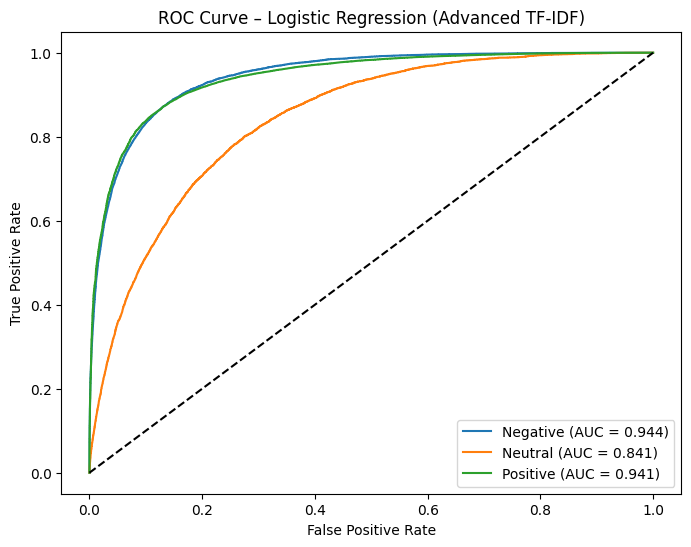

In [65]:
# Get predicted probabilities
y_proba_lr_adv = lr_adv.predict_proba(Xa_test_vec)

# Binarize true labels for multi-class ROC
classes = lr_adv.classes_
y_test_bin = label_binarize(y_test, classes=classes)

# Plot ROC curves
plt.figure(figsize=(8, 6))

for i, class_label in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_proba_lr_adv[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{class_label} (AUC = {roc_auc:.3f})")

# Random classifier reference
plt.plot([0, 1], [0, 1], "k--")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Logistic Regression (Advanced TF-IDF)")
plt.legend()
plt.show()

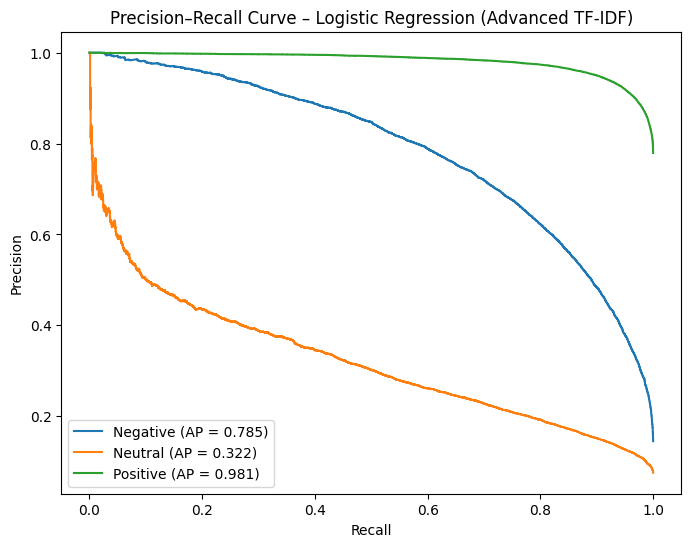

In [66]:
plt.figure(figsize=(8, 6))

for i, class_label in enumerate(classes):
    precision, recall, _ = precision_recall_curve(
        y_test_bin[:, i],
        y_proba_lr_adv[:, i]
    )
    avg_precision = average_precision_score(
        y_test_bin[:, i],
        y_proba_lr_adv[:, i]
    )

    plt.plot(
        recall,
        precision,
        label=f"{class_label} (AP = {avg_precision:.3f})"
    )

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve – Logistic Regression (Advanced TF-IDF)")
plt.legend()
plt.show()

In [67]:
!pip install wordcloud

In [68]:
# Install Hugging Face Transformers and supporting libraries
!pip install -q transformers datasets accelerate

In [69]:
# Check whether a GPU is available and set device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

device(type='cuda')

In [70]:
torch.cuda.is_available()

True

In [71]:
# Display sample reviews and their original scores
df[["Text", "Score"]].head()

,Text,Score
0,I have bought several of the Vitality canned d...,5
1,Product arrived labeled as Jumbo Salted Peanut...,1
2,This is a confection that has been around a fe...,4
3,If you are looking for the secret ingredient i...,2
4,Great taffy at a great price. There was a wid...,5


In [72]:
# Create sentiment labels only if they do not already exist
if "sentiment" not in df.columns:
    def map_sentiment(score):
        if score in [1, 2]:
            return "Negative"
        elif score == 3:
            return "Neutral"
        else:
            return "Positive"

    df["sentiment"] = df["Score"].apply(map_sentiment)

# Verify sentiment label distribution
df["sentiment"].value_counts()

,count
sentiment,
Positive,306758
Negative,57067
Neutral,29754


In [73]:
# Maximum number of samples to take per sentiment class
SAMPLES_PER_CLASS = 10000

# Create a balanced subset of the dataset
df_sub = (
    df[["Text", "sentiment"]]
    .dropna()
    .groupby("sentiment", group_keys=False)
    .apply(
        lambda x: x.sample(
            n=min(len(x), SAMPLES_PER_CLASS),
            random_state=42
        )
    )
    .reset_index(drop=True)
)

# Verify class distribution after subsampling
df_sub["sentiment"].value_counts()

/tmp/ipython-input-362995763.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(


,count
sentiment,
Negative,10000
Neutral,10000
Positive,10000


In [74]:
# Define label mappings
label2id = {
    "Negative": 0,
    "Neutral": 1,
    "Positive": 2
}

id2label = {v: k for k, v in label2id.items()}

# Map sentiment labels to numeric format
df_sub["label"] = df_sub["sentiment"].map(label2id)

# Verify label encoding on random samples
df_sub[["Text", "sentiment", "label"]].sample(5, random_state=42)

,Text,sentiment,label
2308,Received this item today and tried a cup immed...,Negative,0
22404,"I fell in love with this candy in Virginia, wh...",Positive,2
23397,The quality of the pistachios were mostly good...,Positive,2
25058,"I left the feedback couple days ago. Today, I ...",Positive,2
2664,I have bought several flavors of these fruit l...,Negative,0


In [75]:
df_sub["sentiment"].value_counts()

,count
sentiment,
Negative,10000
Neutral,10000
Positive,10000


In [76]:
# Split the balanced subset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    df_sub["Text"],          # raw text input for tokenizer
    df_sub["label"],         # numeric sentiment labels
    test_size=0.2,
    random_state=42,
    stratify=df_sub["label"] # preserve class distribution
)

# Verify split sizes
len(X_train), len(X_test)

(24000, 6000)

In [77]:
# Load the pre-trained DistilBERT tokenizer
tokenizer = DistilBertTokenizerFast.from_pretrained(
    "distilbert-base-uncased"
)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [78]:
# Tokenize training data
train_encodings = tokenizer(
    X_train.tolist(),     # raw text inputs
    truncation=True,      # truncate sequences longer than max_length
    padding=True,         # pad shorter sequences
    max_length=128        # maximum token length
)

# Tokenize test data
test_encodings = tokenizer(
    X_test.tolist(),
    truncation=True,
    padding=True,
    max_length=128
)

In [79]:
class ReviewDataset(torch.utils.data.Dataset):
    """
    Custom PyTorch Dataset for sentiment classification using DistilBERT.
    This class wraps tokenized text encodings and corresponding labels.
    """

    def __init__(self, encodings, labels):
        self.encodings = encodings  # tokenized inputs (input_ids, attention_mask)
        self.labels = labels        # numeric sentiment labels

    def __getitem__(self, idx):
        # Fetch tokenized inputs for a single sample
        item = {
            key: torch.tensor(val[idx])
            for key, val in self.encodings.items()
        }

        # Add label for the sample
        item["labels"] = torch.tensor(self.labels.iloc[idx])
        return item

    def __len__(self):
        # Total number of samples
        return len(self.labels)

In [80]:
# Create PyTorch Dataset objects for training and testing
train_dataset = ReviewDataset(train_encodings, y_train)
test_dataset  = ReviewDataset(test_encodings, y_test)

# Verify dataset sizes
len(train_dataset), len(test_dataset)

(24000, 6000)

In [81]:
# Load pre-trained DistilBERT model for sequence classification
model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=3,          # Negative, Neutral, Positive
    id2label=id2label,     # Map numeric labels back to sentiment names
    label2id=label2id      # Map sentiment names to numeric labels
)

# Move model to GPU if available, otherwise CPU
model.to(device)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [82]:
!pip install -U transformers accelerate

In [83]:
training_args = TrainingArguments(
    output_dir="./results",                 # Directory to save model checkpoints
    learning_rate=2e-5,                     # Standard learning rate for BERT fine-tuning
    per_device_train_batch_size=16,         # Batch size for training
    per_device_eval_batch_size=16,          # Batch size for evaluation
    num_train_epochs=2,                     # Number of training epochs
    weight_decay=0.01,                      # Regularization to reduce overfitting
    logging_dir="./logs",                   # Directory for training logs
    logging_steps=100,                      # Log metrics every 100 steps
    report_to="none"                        # Disable external logging (e.g., WandB)
)

In [84]:
def compute_metrics(eval_pred):
    """
    Compute evaluation metrics for DistilBERT predictions.
    Returns accuracy, macro F1-score, and weighted F1-score.
    """
    logits, labels = eval_pred

    # Convert logits to predicted class labels
    preds = logits.argmax(axis=1)

    return {
        "accuracy": accuracy_score(labels, preds),
        "macro_f1": f1_score(labels, preds, average="macro"),
        "weighted_f1": f1_score(labels, preds, average="weighted"),
    }

In [85]:
trainer = Trainer(
    model=model,                   # DistilBERT sequence classification model
    args=training_args,             # Training configuration
    train_dataset=train_dataset,    # Training dataset
    eval_dataset=test_dataset,      # Evaluation dataset
    tokenizer=tokenizer,            # Tokenizer for preprocessing
    compute_metrics=compute_metrics # Custom evaluation metrics
)

/tmp/ipython-input-1150604508.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [86]:
trainer.train()

Step,Training Loss
100,0.946700
200,0.739700
300,0.691700
400,0.691700
500,0.681200
600,0.657300
700,0.643000
800,0.641600
900,0.642700
1000,0.665500


TrainOutput(global_step=3000, training_loss=0.5827250366210938, metrics={'train_runtime': 636.0999, 'train_samples_per_second': 75.46, 'train_steps_per_second': 4.716, 'total_flos': 1589637132288000.0, 'train_loss': 0.5827250366210938, 'epoch': 2.0})

In [87]:
eval_results = trainer.evaluate()
eval_results

{'eval_loss': 0.6116002798080444,
 'eval_accuracy': 0.7451666666666666,
 'eval_macro_f1': 0.7468397199517841,
 'eval_weighted_f1': 0.7468397199517841,
 'eval_runtime': 22.9219,
 'eval_samples_per_second': 261.758,
 'eval_steps_per_second': 16.36,
 'epoch': 2.0}

In [88]:
# Run prediction on the test dataset
predictions = trainer.predict(test_dataset)

# Convert logits to predicted class labels
y_pred = predictions.predictions.argmax(axis=1)

# True labels
y_true = predictions.label_ids

In [89]:
print("DistilBERT Classification Report")
print(
    classification_report(
        y_true,
        y_pred,
        target_names=["Negative", "Neutral", "Positive"],
        digits=4
    )
)

DistilBERT Classification Report
              precision    recall  f1-score   support

    Negative     0.7557    0.7330    0.7442      2000
     Neutral     0.6398    0.6875    0.6628      2000
    Positive     0.8530    0.8150    0.8335      2000

    accuracy                         0.7452      6000
   macro avg     0.7495    0.7452    0.7468      6000
weighted avg     0.7495    0.7452    0.7468      6000



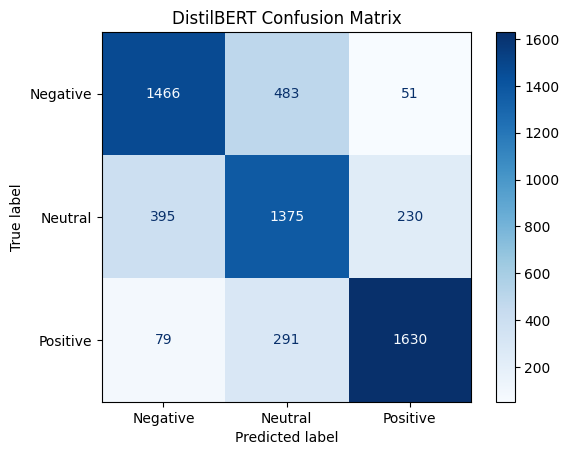

In [90]:
# Plot confusion matrix for DistilBERT predictions
ConfusionMatrixDisplay.from_predictions(
    y_true,
    y_pred,
    display_labels=["Negative", "Neutral", "Positive"],
    cmap="Blues",
    values_format="d"
)

plt.title("DistilBERT Confusion Matrix")
plt.show()

In [91]:
# Example unseen reviews
unseen_reviews = [
    "The product is fine but nothing special",
    "I am extremely disappointed with this purchase",
    "Absolutely fantastic quality and performance"
]

# Create DataFrame
unseen_df = pd.DataFrame({"Text": unseen_reviews})

# Tokenize unseen data
unseen_encodings = tokenizer(
    unseen_df["Text"].tolist(),
    truncation=True,
    padding=True,
    max_length=128
)

# Convert to tensors
unseen_inputs = {
    key: torch.tensor(val).to(device)
    for key, val in unseen_encodings.items()
}

# Disable gradients for inference
with torch.no_grad():
    outputs = model(**unseen_inputs)

# Get predictions
unseen_preds = outputs.logits.argmax(dim=1).cpu().numpy()

# Map predictions back to sentiment labels
unseen_df["Predicted Sentiment"] = [id2label[p] for p in unseen_preds]

unseen_df

,Text,Predicted Sentiment
0,The product is fine but nothing special,Neutral
1,I am extremely disappointed with this purchase,Negative
2,Absolutely fantastic quality and performance,Positive


In [92]:
# Ask user for input
user_review = input("Enter a product review to analyze sentiment: ")

# Tokenize user input
user_encodings = tokenizer(
    [user_review],
    truncation=True,
    padding=True,
    max_length=128,
    return_tensors="pt"
)

# Move to device
user_encodings = {k: v.to(device) for k, v in user_encodings.items()}

# Predict sentiment
with torch.no_grad():
    outputs = model(**user_encodings)

user_pred = outputs.logits.argmax(dim=1).item()

print("Predicted Sentiment:", id2label[user_pred])

Enter a product review to analyze sentiment: It is neither good nor bad, just acceptable
Predicted Sentiment: Neutral


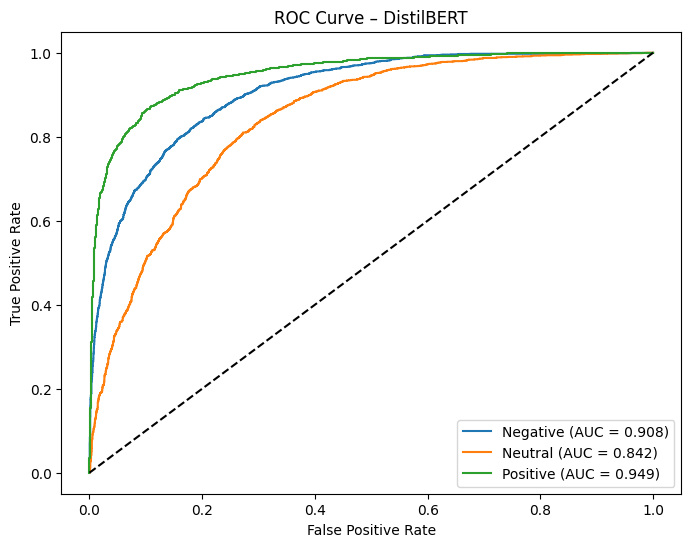

In [93]:
# Get probabilities from predictions
y_proba = torch.softmax(
    torch.tensor(predictions.predictions),
    dim=1
).numpy()

# Binarize true labels
y_true_bin = label_binarize(y_true, classes=[0, 1, 2])

# Plot ROC curves
plt.figure(figsize=(8, 6))

for i, label in enumerate(["Negative", "Neutral", "Positive"]):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{label} (AUC = {roc_auc:.3f})")

# Random baseline
plt.plot([0, 1], [0, 1], "k--")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – DistilBERT")
plt.legend()
plt.show()

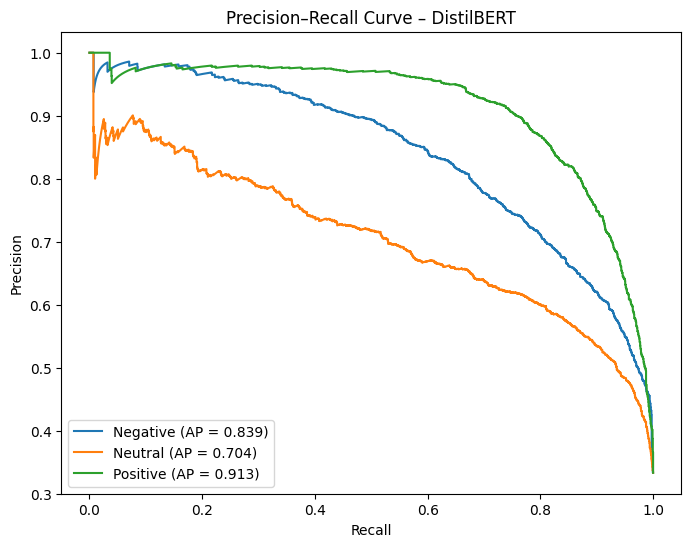

In [94]:
plt.figure(figsize=(8, 6))

for i, label in enumerate(["Negative", "Neutral", "Positive"]):
    precision, recall, _ = precision_recall_curve(
        y_true_bin[:, i],
        y_proba[:, i]
    )
    avg_precision = average_precision_score(
        y_true_bin[:, i],
        y_proba[:, i]
    )

    plt.plot(
        recall,
        precision,
        label=f"{label} (AP = {avg_precision:.3f})"
    )

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve – DistilBERT")
plt.legend()
plt.show()

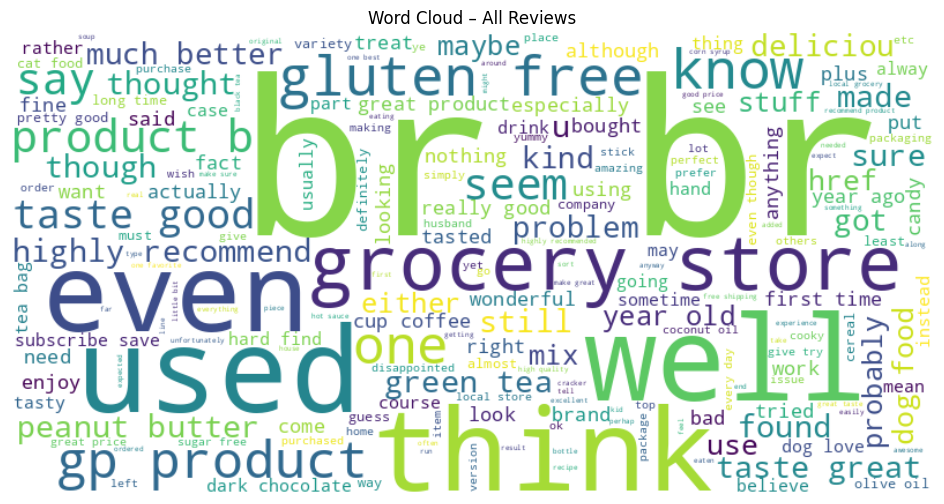

In [95]:
# Combine all advanced cleaned text
all_text = " ".join(df["clean_text_adv"])

# Generate word cloud
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color="white",
    max_words=200
).generate(all_text)

# Plot word cloud
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud – All Reviews")
plt.show()

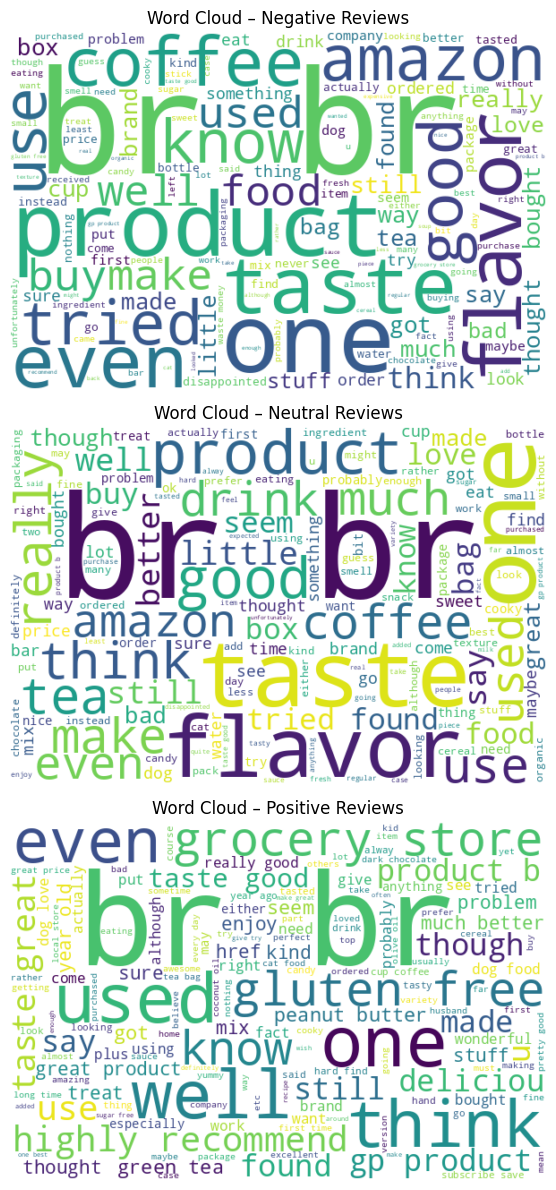

In [98]:
# Word Clouds by Sentiment Class

sentiments = ["Negative", "Neutral", "Positive"]

plt.figure(figsize=(18, 12))

for i, sentiment in enumerate(sentiments, 1):
    text = " ".join(df[df["sentiment"] == sentiment]["clean_text_adv"])

    wc = WordCloud(
        width=600,
        height=400,
        background_color="white",
        max_words=150
    ).generate(text)

    plt.subplot(3, 1, i)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Word Cloud – {sentiment} Reviews")

plt.tight_layout()
plt.show()

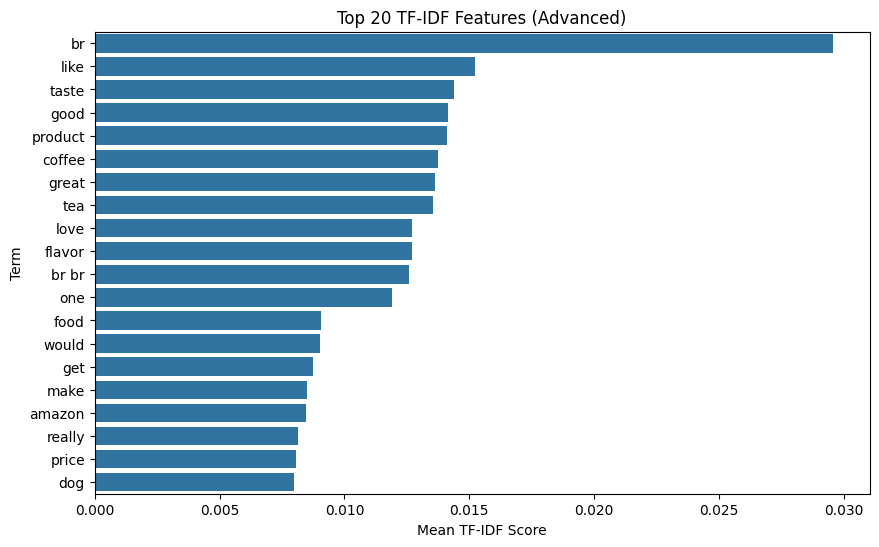

In [97]:
# Top TF-IDF Features (Advanced)

feature_names_adv = tfidf_adv.get_feature_names_out()
mean_tfidf_adv = Xa_train_vec.mean(axis=0).A1

tfidf_adv_df = pd.DataFrame({
    "term": feature_names_adv,
    "score": mean_tfidf_adv
})

top_terms_adv = tfidf_adv_df.sort_values(by="score", ascending=False).head(20)

plt.figure(figsize=(10, 6))
sns.barplot(
    data=top_terms_adv,
    x="score",
    y="term"
)
plt.title("Top 20 TF-IDF Features (Advanced)")
plt.xlabel("Mean TF-IDF Score")
plt.ylabel("Term")
plt.show()